Goal of clustering:
Low intercluster similarity
high intracluster similarity

Intrinsic: evaluate quality of clusters based on information inherent in the data and the structure of the clusters themselves
- evaluation without groundtruth values/ targets
- Silhouette, Dunn's Index

Extrinsic: assess how well the clustering aligns with this external information
- either comparision with ground truth or compare 2 or more algos
- Rand's Index, Adjusted Mutual Information

In [80]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score, rand_score, davies_bouldin_score, adjusted_rand_score, homogeneity_completeness_v_measure
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [59]:
data = pd.read_csv('/content/Class_Seeds.csv')

In [60]:
data.head()

,Area,Perimeter,Compactness,KernelLength,KernelWidth,AsymCoeff,KernelGrov_Length,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [61]:
data.shape

(210, 8)

In [62]:
data.dtypes

Area                 float64
Perimeter            float64
Compactness          float64
KernelLength         float64
KernelWidth          float64
AsymCoeff            float64
KernelGrov_Length    float64
Class                  int64
dtype: object

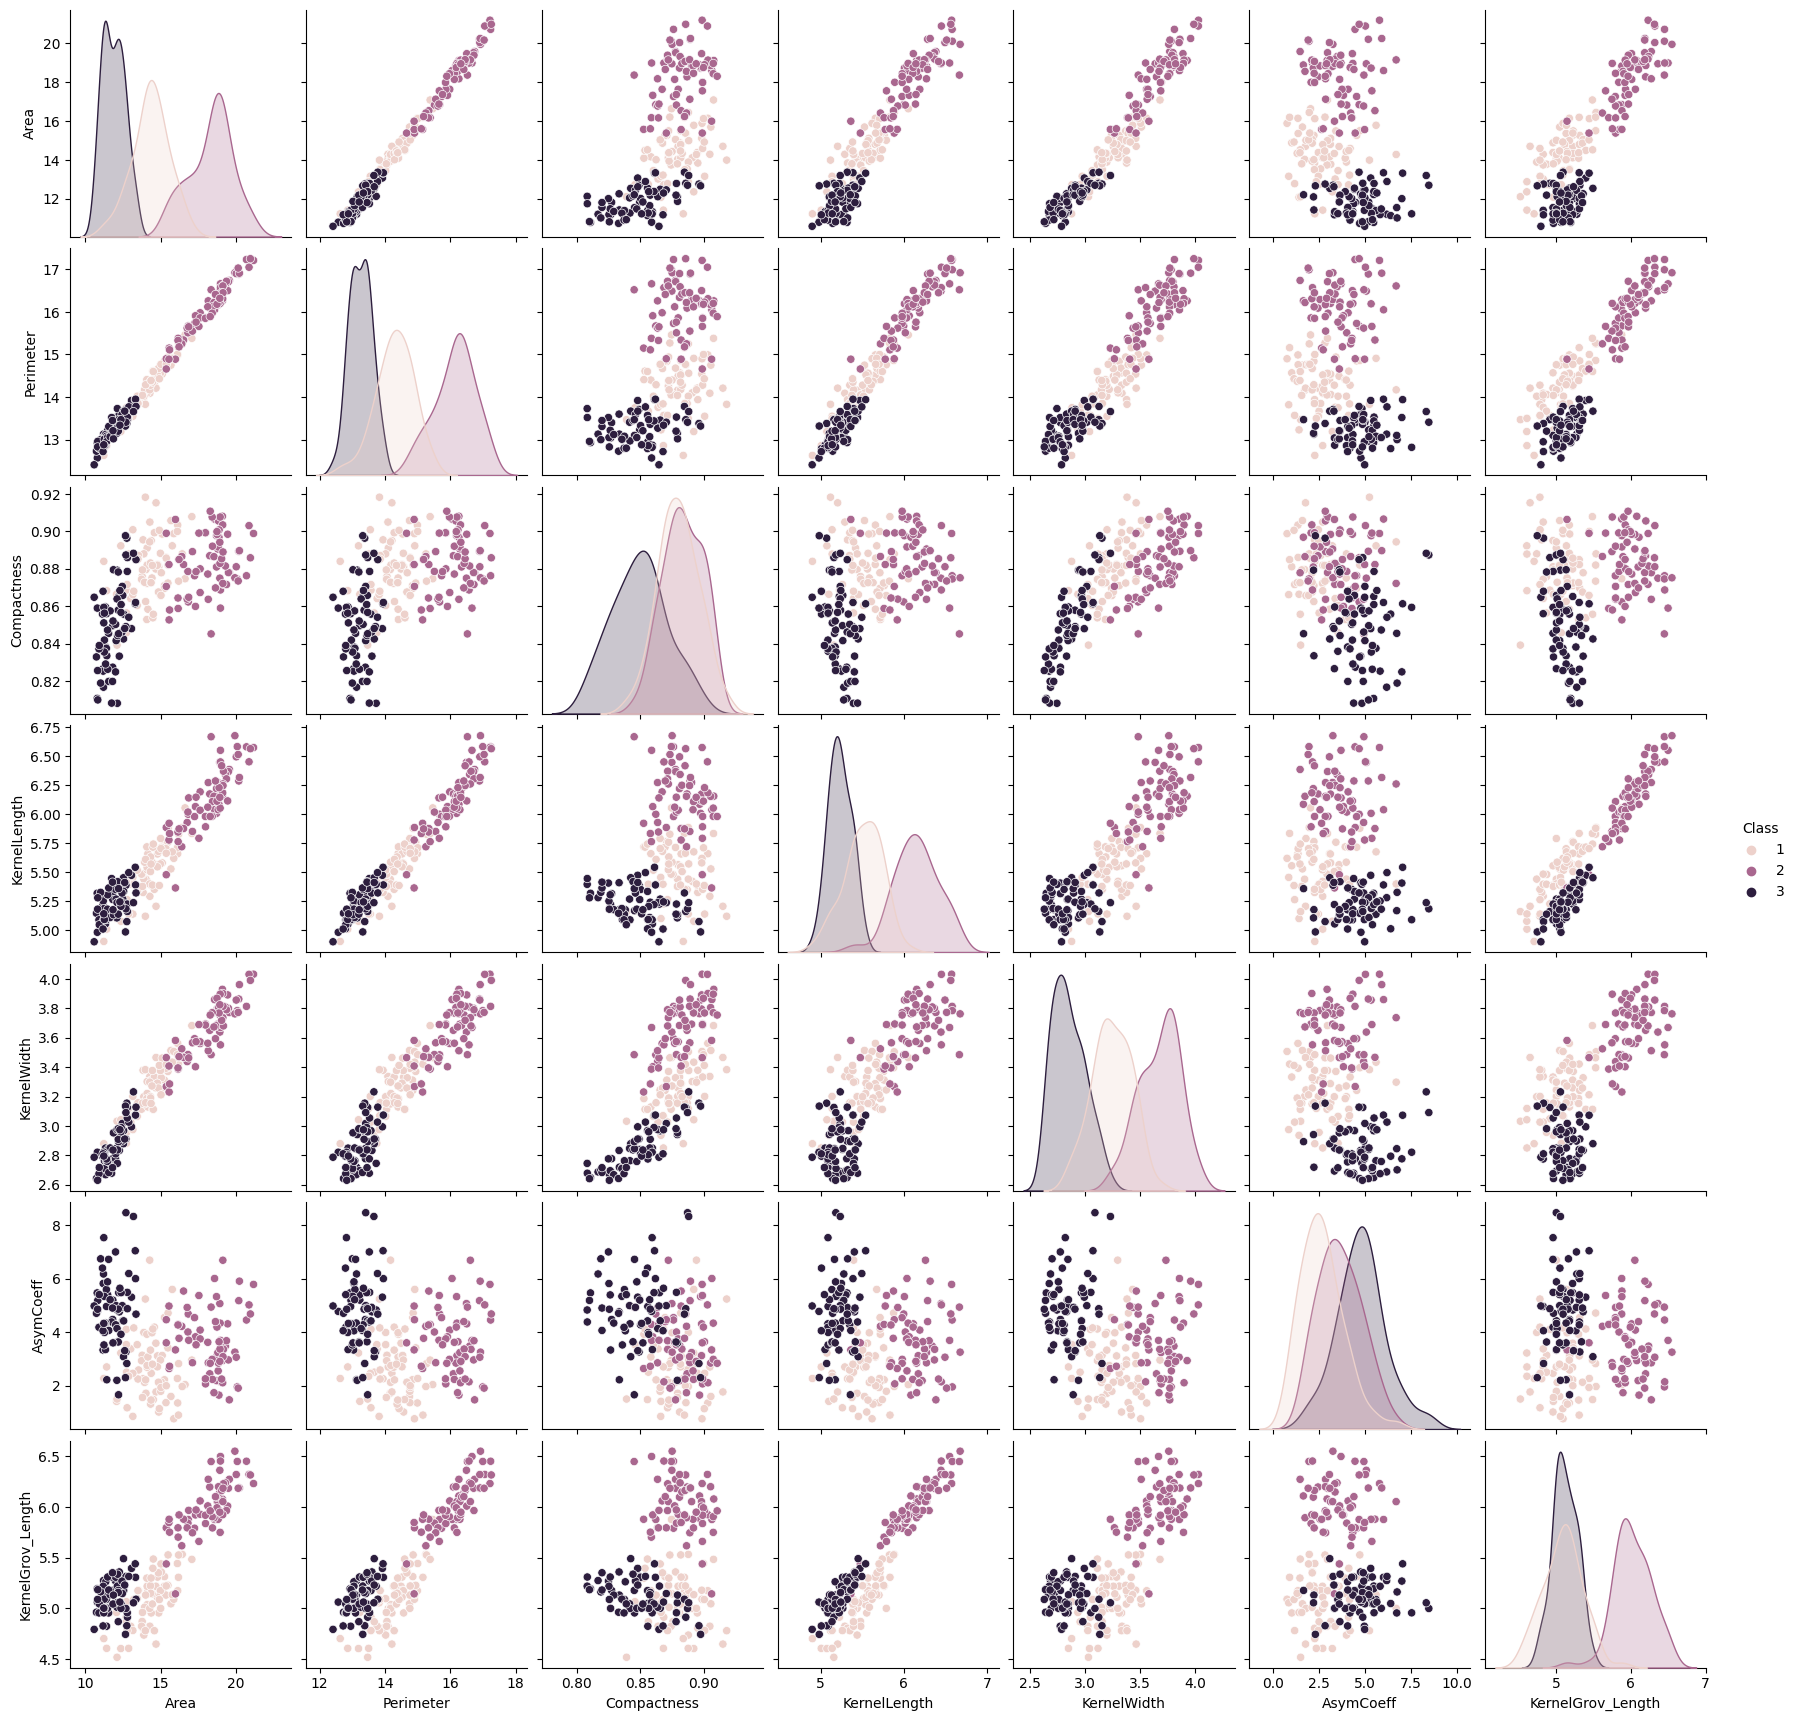

In [81]:
sns.pairplot(data, hue='Class')

as you can see the clusters are not very seperated and are overlapping a little. this will certainly reflect in our evaluation metrics

In [63]:
data_ = data.drop(columns=['Class'], axis=1)

In [64]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data_)

## Silhouette Score
quantifies how well-separated clusters based on compactness of datapoints within the cluster and its seperation from other clusters

Range: -1 to +1 (higher value, better model) (score around 0 indicates overlapping clusters)

Use: as a starter intrinsic metric to assess the clusters, validate results, and idetify overlapping or missclassified points useful for further analysis



In [77]:
clus = KMeans(n_clusters=3, init='k-means++', random_state=2, max_iter=100)
labels = clus.fit_predict(scaled)
silhouette_avg = silhouette_score(scaled, labels)
print(silhouette_avg)

0.40072705527512986


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

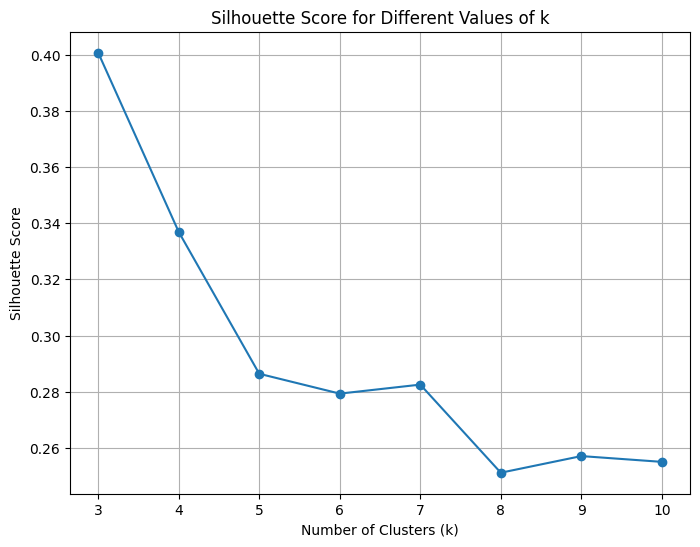

In [78]:
k_values = range(3, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled)
    silhouette_avg = silhouette_score(scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Values of k')
plt.xticks(k_values)
plt.grid(True)
plt.show()


## Dunn Index

No formula available directly to implement


assesses the compactness of clusters and separation between clusters.

Range: 0 to inf (higher is better)

Points to remember:
- serves as a guideline for cluster quality but should not be solely relied upon
- beneficial when used with other evaluation metrics
- assumes small intra cluster and big inter-cluster distance which might not be true eg. overlapping clusters

Use
- For comparing different algos and cluster validation

Don't use:
- clusters with significant size difference
- high dimensional data where calculating euclidean distance is not feasible
- irregular shapes and densities of clusters

In [87]:
from sklearn.metrics.pairwise import euclidean_distances

def dunn_index(X, labels):
    num_clusters = len(np.unique(labels))
    cluster_distances = [euclidean_distances(X[labels == i]) for i in range(num_clusters)]

    # Compute within-cluster variation (minimum distance within clusters)
    min_within_cluster = np.inf
    for i in range(num_clusters):
        distances = cluster_distances[i][np.triu_indices(len(cluster_distances[i]), k=1)]
        if len(distances) > 0:
            within_cluster = np.min(distances)
            if within_cluster < min_within_cluster:
                min_within_cluster = within_cluster

    # Compute inter-cluster distance (maximum distance between clusters)
    max_inter_cluster = 0.0
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            inter_cluster = np.min(euclidean_distances(X[labels == i], X[labels == j]))
            if inter_cluster > max_inter_cluster:
                max_inter_cluster = inter_cluster

    if max_inter_cluster == 0.0:
        return np.nan  # To avoid division by zero

    dunn_index_value = min_within_cluster / max_inter_cluster
    return dunn_index_value


dunn_score = dunn_index(scaled, labels)
print("Dunn Index:", dunn_score)

Dunn Index: 0.08671478527821067


## Davies-Bouldin Index

Measures the average similarity between each cluster and its most similar cluster

Range: 0 to inf (lower is better)

Points to remember:
- serves as a guideline for cluster quality but should not be solely relied upon
- beneficial when used with other evaluation metrics
- assumes small intra cluster and big inter-cluster distance which might not be true eg. overlapping clusters

(similar to Dunn Index but actually available in sklearn)
Use
- For comparing different algos and cluster validation

Don't use:
- clusters with significant size difference
- high dimensional data
- irregular shapes and densities of clusters

In [79]:
db_score = davies_bouldin_score(scaled, labels)
print("Davies_Bouldin_Score: ", db_score)

Davies_Bouldin_Score:  0.9278712249013426


#Extrinsic

In [82]:
ground_labels = data['Class']

## V-Measure

assesses the effectiveness of clustering by considering both homogeneity (extent to which each cluster contains members of only a single class) and completeness(extent to which all members of a given class are assigned to the same cluster) with respect to ground truth labels

Range: 0 to 1 (higher is better)

Points to remember:
- sensitive to class imbalance and cluster imbalance
- assumes ground truth labels are given

Use:
- Evaluating clustering results when ground truth labels are available.
- Comparing different clustering algorithms' performance against true labels.

Don't use:
- scenarios where ground truth labels are unavailable/unreliable
- imbalanced datasets

In [84]:
hcv_score = homogeneity_completeness_v_measure(ground_labels, labels)
print('Homogenity_Completeness_V-Measure Score: ', hcv_score)

Homogenity_Completeness_V-Measure Score:  (0.7277053952805549, 0.7280229633940751, 0.7278641446984669)


## Rand Index

similarity between two sets of data by counting no. of agreements and disagreements between pairs of samples with respect to their clustering assignments

Range: 0 to 1 (higher is better)

Points to remember
- symmetric and does not penalize different permutations of the same clustering
- focuses on the consistency of pair-wise relationships between points in the clusterings being compared, disregarding differences in labeling or numbering of clusters

Use:
- Evaluating the performance of clustering algorithms by comparing their results against ground truth labels
- Assessing the similarity between two different clusterings

Dont Use:
- Not suitable when comparing different clusterings with different numbers of clusters

### Adjusted RI

accounts for chance, more robust

 Range: -0.5 and 1.0 (Random labelings have an ARI close to 0.0. 1.0 stands for perfect match)

Chance refers to randomness and randomness might arise when
- random initialization of clusters
- random-sampling or similar measures used on data
- noisy data
- incomplete/unreliable labels

In [85]:
rand_index = rand_score(ground_labels, labels)
print("Rand Index: ", rand_index)

Rand Index:  0.8997038049669629


In [86]:
ari = adjusted_rand_score(ground_labels, labels)
print("ARI: ", ari)

ARI:  0.7732937360806309
